# Core

> Lisette Core

In [1]:
#| default_exp core

In [2]:
#| hide
from cachy import enable_cachy

In [3]:
#| hide
enable_cachy()

In [201]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string
from typing import Optional
from html import escape
from IPython.display import Markdown
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info)
from litellm.utils import function_to_dict, StreamingChoices, Delta
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore import imghdr
from fastcore.xml import ToolCalls, ToolCall, Arguments, Result

In [5]:
#| hide
from fastcore.test import *
from IPython.display import Image
from fastcore.xtras import SaveReturn
from fastcore.test import *

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [6]:
#| export
def patch_litellm():
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

In [7]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [8]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [9]:
ms = ["gemini/gemini-2.5-flash", "claude-sonnet-4-20250514", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-2.5-flash:**

Hey there yourself! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=113, prompt_tokens=4, total_tokens=117, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=102, rejected_prediction_tokens=None, text_tokens=11), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-sonnet-4-20250514:**

Hello! Nice to meet you! How are you doing today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=10, total_tokens=26, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hello! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images).

In [10]:
#| export
def _mk_img(data:bytes)->tuple:
    "Convert image bytes to a base64 encoded image"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map["."+imghdr.what(None, h=data)]
    return img, mtype

In [11]:
#| export
def _is_img(data): 
    return isinstance(data, bytes) and bool(imghdr.what(None, data))

def _add_cache_control(msg,          # LiteLLM formatted msg
                       cache=False,  # Enable Anthropic caching
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    if not cache: return msg
    if isinstance(msg["content"], str): 
        msg["content"] = [{"type": "text", "text": msg["content"]}]
    cache_control = {"type": "ephemeral"}
    if ttl is not None: cache_control["ttl"] = ttl
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1]["cache_control"] = cache_control
    return msg

def _remove_cache_ckpts(msg):
    "remove unnecessary cache checkpoints."
    if isinstance(msg["content"], list) and msg["content"]:
        msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    if _is_img(o): 
        img, mtype = _mk_img(o)
        return {"type": "image_url", "image_url": f"data:{mtype};base64,{img}"}
    return o

def mk_msg(content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
           role="user",  # Message role if content isn't already a dict/Message
           cache=False,  # Enable Anthropic caching
           ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    return _add_cache_control({"role": role, "content": c}, cache=cache, ttl=ttl)

Now we can use mk_msg to create different types of messages:

Simple text:

In [12]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Lists w just one string element are flattened for conciseness:

In [13]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

With Anthropic caching:

In [14]:
msg = mk_msg("hey I'm Rens. Please repeat it in all caps w a fun greeting",cache=True)
msg

{'role': 'user',
 'content': [{'type': 'text',
   'text': "hey I'm Rens. Please repeat it in all caps w a fun greeting",
   'cache_control': {'type': 'ephemeral'}}]}

(LiteLLM ignores these fields when sent to other providers)

Text and images:

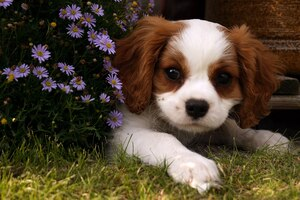

In [15]:
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

In [16]:
msg = mk_msg(['hey what in this image?',fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


Which can be passed to litellm's `completion` function like this:

In [17]:
model = ms[1]

In [18]:
completion(model,[msg])

This image shows an adorable puppy with distinctive brown and white markings on its face. The puppy appears to be a small breed, possibly a Cavalier King Charles Spaniel or similar breed, with fluffy reddish-brown and white fur. The puppy is positioned near some purple flowers (which look like small daisies or asters) and is sitting on grass. The setting appears to be outdoors in a garden area, creating a sweet, natural portrait of this very cute young dog. The puppy has dark eyes and the classic innocent, gentle expression that makes puppies so endearing.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=131, prompt_tokens=104, total_tokens=235, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Now lets make it easy to provide entire conversations:

In [19]:
#| export
def mk_msgs(msgs,                       # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
            cache=False,                # Enable Anthropic caching
            ttl=None,                   # Cache TTL: '5m' (default) or '1h'
            cache_last_ckpt_only=True   # Only cache the last message
           ):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    for m in msgs:
        res.append(msg:=mk_msg(m, role=role,cache=cache))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache_last_ckpt_only: res = [_remove_cache_ckpts(m) for m in res]
    if res and cache: res[-1] = _add_cache_control(res[-1], cache=cache, ttl=ttl)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [20]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [21]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [22]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [23]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [24]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [25]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [26]:
msgs = mk_msgs([['Whats in this img?',fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [27]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [28]:
r = completion(model, mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [29]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hello! How are you doing today? Is there anything I can help you with?

In [30]:
r2.value

Hello! How are you doing today? Is there anything I can help you with?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=20, prompt_tokens=9, total_tokens=29, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [31]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [32]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [33]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [34]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible.")
r = completion(model, [tmsg], tools=[toolsc])

In [35]:
display(r)

I'll help you calculate both of those addition problems using the simple_add tool. Let me perform both calculations for you:

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=160, prompt_tokens=475, total_tokens=635, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [36]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = call_func(tc.function.name, fargs,ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [37]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'toolu_013MZMqJL4fBRGTsMtAGJjMk',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'toolu_01HkbM4zwAb38n4rH7SNvi75',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [38]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [39]:
r = completion(messages=[tmsg], model=model, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I'll help you calculate both of those sums using the addition tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979
🔧 simple_add

🔧 simple_add


In [40]:
r2.value

I'll help you calculate both of those sums using the addition tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=197, prompt_tokens=475, total_tokens=672, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [41]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = completion(messages=[msg], model=model, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')


🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'll find the derivative of f(x) = x³ + 2x² - 5x + 1 using the power rule.

The power rule states that for any term ax^n, the derivative is nax^(n-1).

Taking the derivative of each term:

**Term 1:** x³
- Derivative: 3x^(3-1) = 3x²

**Term 2:** 2x²  
- Derivative: 2 × 2x^(2-1) = 4x

**Term 3:** -5x
- Derivative: -5 × 1x^(1-1) = -5

**Term 4:** 1 (constant)
- Derivative: 0

**Final Answer:**
f'(x) = 3x² + 4x - 5

In [42]:
r2.value

I'll find the derivative of f(x) = x³ + 2x² - 5x + 1 using the power rule.

The power rule states that for any term ax^n, the derivative is nax^(n-1).

Taking the derivative of each term:

**Term 1:** x³
- Derivative: 3x^(3-1) = 3x²

**Term 2:** 2x²  
- Derivative: 2 × 2x^(2-1) = 4x

**Term 3:** -5x
- Derivative: -5 × 1x^(1-1) = -5

**Term 4:** 1 (constant)
- Derivative: 0

**Final Answer:**
f'(x) = 3x² + 4x - 5

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=433, prompt_tokens=66, total_tokens=499, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=205, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [43]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i['search_context_cost_per_query'] or i['supports_web_search'])

In [44]:
for m in ms: print(m, _has_search(m))

gemini/gemini-2.5-flash True
claude-sonnet-4-20250514 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [45]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = completion(model, [smsg], web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are fascinating semiaquatic mammals that belong to the weasel family. The charismatic otter, a member of the weasel family, is found on every continent except Australia and Antarctica. There are 13 species in total, ranging from the small-clawed otter to the giant otter.

Most are small, with short ears and noses, elongated bodies, long tails, and soft, dense fur. Otters have the densest fur of any animal—as many as a million hairs per square inch in places. Webbed feet and powerful tails, which act like rudders, make otters strong swimmers.

All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters have a unique feeding behavior: A sea otter will float on its back, place a rock on its chest, then smash the mollusk down on it until it breaks open. River otters, however, can hold their breath for up to 8 minutes.

River otters are especially playful, gamboling on land and splashing into rivers and streams. Otters live up to 16 years; they are by nature playful, and frolic in the water with their pups. When resting, sea otters entangle themselves in kelp so they don't float away.

Many otter species face conservation challenges. Otters and their mustelid relatives were once hunted extensively for their fur, many to the point of near extinction. Despite regulations designed to protect them, many species remain at risk from pollution and habitat loss.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=603, prompt_tokens=13314, total_tokens=13917, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), server_tool_use=ServerToolUse(web_search_requests=1), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [46]:
r.choices[0].message.provider_specific_fields['citations'][0]

[{'type': 'web_search_result_location',
  'cited_text': 'The charismatic otter, a member of the weasel family, is found on every continent except Australia and Antarctica. ',
  'url': 'https://www.nationalgeographic.com/animals/mammals/facts/otters-1',
  'title': 'Otters, facts and information | National Geographic',
  'encrypted_index': 'Eo8BCioIBxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDLIIDjwxPgKn3T1dcBoMOiqvShGJLxd8+SdzIjCz3SlTIqO2HA5gvks2pAQGmz3XWB+xFAaljcWlyygSy/kTY7sqeqMn1qU4tGpBmf4qE4abQbfNHbLywouCbZ9quTv0iwgYBA=='}]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [47]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [48]:
r = list(completion(model, [smsg], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://greatergood.org/blog/9-facts-about-the-small-clawed-otter "9 Facts About Small-Clawed Otters And how you can save them") the small-clawed otter (the smallest species) to [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the giant otter and sea otter (the largest).

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Most are small, with short ears and noses, elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch, which keeps them warm in water. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") They have webbed feet and powerful tails that act like rudders, making them strong swimmers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters are famous for [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") floating on their backs and using rocks to smash open shellfish. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") Sea otters can stay submerged for more than 5 minutes, while river otters can hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding and splashing. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters even entangle themselves in kelp while sleeping and sometimes hold hands with other otters to stay together.

Many otter species face conservation challenges due to [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") historical hunting for their fur and current threats from pollution and habitat loss.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=576, prompt_tokens=13314, total_tokens=13890, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

# Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [49]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [50]:
#| export
def _mk_prefill(pf): return ModelResponseStream([StreamingChoices(delta=Delta(content=pf,role='assistant'))])

In [51]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False               # Anthropic prompt caching
    ):
        "LiteLLM chat client."
        self.model = model
        hist,tools = mk_msgs(hist),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if msg: self.hist = mk_msgs(self.hist+[msg], cache=self.cache)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf

    def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        if step>max_steps: return
        if not get_model_info(self.model)["supports_assistant_prefill"]: prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = completion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, 
                         tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp),
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = yield from stream_with_complete(res,postproc=cite_footnotes)
        m = res.choices[0].message
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results=[_lite_call_func(tc, ns=self.ns) for tc in tcs]
            self.hist+=tool_results
            for r in tool_results: yield r
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            yield from self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice, **kwargs)
    
    def __call__(self,
                 msg=None,          # Message str, or list of multiple message parts
                 prefill=None,      # Prefill AI response if model supports it
                 temp=None,         # Override temp set on chat initialization
                 think=None,        # Thinking (l,m,h)
                 search=None,       # Override search set on chat initialization (l,m,h)
                 stream=False,      # Stream results
                 max_steps=2, # Maximum number of tool calls
                 final_prompt=None, # Final prompt when tool calls have ran out 
                 return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                 **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

In [197]:
pr = "What is 5 + 7? Use the tool to calculate it."
c = Chat(model, tools=[simple_add])
res = c(pr)

In [184]:
for r in c.hist: print(r)

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}
Message(content="I'll use the add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'add'}, 'id': 'toolu_01KuvMvqdB4ZbigRRZ5ga9UP', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})
{'tool_call_id': 'toolu_01KuvMvqdB4ZbigRRZ5ga9UP', 'role': 'tool', 'name': 'add', 'content': '12'}
Message(content='The result of 5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})


In [185]:
tcq = Message(content="I'll use the add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'add'}, 'id': 'toolu_01KuvMvqdB4ZbigRRZ5ga9UP', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})
tcq

Message(content="I'll use the add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='add'), id='toolu_01KuvMvqdB4ZbigRRZ5ga9UP', type='function')], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})

In [190]:
c = Chat(model, hist=["What is 5 + 7? Use the tool to calculate it.", tcq], tools=[add])

In [191]:
for r in c.hist: print(r)

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}
Message(content="I'll use the add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'add'}, 'id': 'toolu_01KuvMvqdB4ZbigRRZ5ga9UP', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})


In [192]:
c(tcr)

The result of 5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=521, total_tokens=538, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [77]:
for o in res: 
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)

I'll use the async_add tool to calculate 5 + 7 for you.
🔧 async_add
{'tool_call_id': 'toolu_01NTrwnCZYd6K7ZeNQtUyx9k', 'role': 'tool', 'name': 'async_add', 'content': '12'}
The result of 5 + 7 is 12.

In [126]:
mr = [o for o in os if isinstance(o, ModelResponse) and (c := getattr(o.choices[0].message, 'tool_calls', None))][0]
print(mr)

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-20250514', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll use the async_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'async_add'}, 'id': 'toolu_01NTrwnCZYd6K7ZeNQtUyx9k', 'type': 'function'}], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=91, prompt_tokens=424, total_tokens=515, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None))


In [144]:
tc = mr.choices[0].message.tool_calls[0]
ToolCall(Arguments(tc['function']['arguments']), id=tc['id'], name=tc['function']['name'], status="complete")

```html
<toolcall id="toolu_01NTrwnCZYd6K7ZeNQtUyx9k" name="async_add" status="complete"><arguments>{"a": 5, "b": 7}</arguments></toolcall>
```

In [52]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

## Examples

### History tracking

In [53]:
chat = Chat(model)
res = chat("Hey my name is Rens")
res

Hi Rens! Nice to meet you. How are you doing today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=19, prompt_tokens=14, total_tokens=33, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [54]:
chat("Whats my name")

Your name is Rens! You introduced yourself to me at the start of our conversation.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=22, prompt_tokens=41, total_tokens=63, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

See now we keep track of history!

History is stored in the `hist` attribute:

In [55]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content='Hi Rens! Nice to meet you. How are you doing today?', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None}),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens! You introduced yourself to me at the start of our conversation.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})]

You can also pass an old chat history into new Chat objects:

In [56]:
chat2 = Chat(model, hist=chat.hist)
chat2("What was my name again?")

Your name is Rens - you told me that when you first said hello.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=20, prompt_tokens=72, total_tokens=92, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [294]:
pr = "What is 5 + 7? Use the tool to calculate it."
c = Chat(model, tools=[simple_add])
res = c(pr)

In [295]:
#| export
@patch
def print_hist(self:Chat):
    "Print the history"
    for r in self.hist: print(r, end='\n\n')

Whereas normally without tools we would get one user input and one assistant response, we get two extra messages in between, one is an assitant message which requests the tool to be used and the next is a tool response with the result to the tool call.

In [296]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_015yBzHuirWKDN14GbYJHeyY', 'type': 'function'}], function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})

{'tool_call_id': 'toolu_015yBzHuirWKDN14GbYJHeyY', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='The result of 5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})



Now lets try to build this up manually so we have full control over the inputs.

In [297]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [298]:
random_tool_id()

'toolu_Lpjh14qO5hytgw9t9xLtZ32Ep'

A tool call request can contain one more or more tool calls. Lets make one.

In [299]:
#| export
def mk_tc(func, idx=1, **kwargs):
    args = json.dumps(kwargs)
    if callable(func): func = func.__name__
    id = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': id, 'type': 'function'}

In [301]:
tc = mk_tc(simple_add, a=5, b=7)
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_sck8qW2f3Bt0auOQBHwdCbRaF',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [305]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [306]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_sck8qW2f3Bt0auOQBHwdCbRaF', type='function')], function_call=None, provider_specific_fields=None)

In [307]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [308]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_sck8qW2f3Bt0auOQBHwdCbRaF', type='function')], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [309]:
tcr = {'tool_call_id': 'toolu_01KuvMvqdB4ZbigRRZ5ga9UP', 'role': 'tool', 'name': 'add', 'content': '12'}

In [310]:
def mk_tc_result(tc, result): return {'tool_call_id': tc.id, 'role': 'tool', 'name': tc.function.name, 'content': result}

In [311]:
tcq.tool_calls[0]

ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_sck8qW2f3Bt0auOQBHwdCbRaF', type='function')

In [270]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_tYljL6Vyoi1IrLu5cUvGr1F1f',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [271]:
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

In [272]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_tYljL6Vyoi1IrLu5cUvGr1F1f',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

In [273]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}
Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_tYljL6Vyoi1IrLu5cUvGr1F1f', type='function')], function_call=None, provider_specific_fields=None)


In [274]:
c(tcr[0])

The result of 5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=537, total_tokens=554, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [275]:
details = """
<details>{'args':{'a': 1, 'b':2}, 'name':'add','result':3}</details>
"""

In [292]:
pr = "What is 5 + 7 and 6+7? Use the tool to calculate it. And use multiple tools in your tool call"
c = Chat(model, tools=[simple_add])
res = c(pr)

### Images

In [57]:
chat(['Whats in this img?',fn.read_bytes()])

This image shows an adorable puppy! It appears to be a Cavalier King Charles Spaniel or a similar breed with beautiful reddish-brown and white fur. The puppy has sweet, dark eyes and is lying on grass near some purple flowers (they look like small daisies or asters). The puppy looks very young and has that irresistibly cute, fluffy appearance that makes you want to give it a cuddle. It's a really lovely, heartwarming photo!

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=109, prompt_tokens=164, total_tokens=273, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Prefill

Prefill works as expected:

In [58]:
chat("Spell my name",prefill="Your name is R E")

Your name is R E N S.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=285, total_tokens=291, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

And the entire message is stored in the history, not just the generated part:

In [59]:
chat.hist[-1]

Message(content='Your name is R E N S.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})

### Streaming

In [60]:
from time import sleep

In [61]:
chat = Chat(model)
stream_gen = chat("Count to 5", stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

1
2
3
4
5

1
2
3
4
5

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=11, total_tokens=24, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

Lets try prefill with streaming too:

In [62]:
stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
for chunk in stream_gen:
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

Okay! 6, 7, 8, 9, 10.

Okay! 6, 7, 8, 9, 10.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=40, total_tokens=53, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Tool use

Ok now lets test tool use

In [63]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-2.5-flash:**

The `simple_add` tool was used to calculate the sum of 5 and 3. The tool returned 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=26, prompt_tokens=119, total_tokens=145, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=119, image_tokens=None))`

</details>

**claude-sonnet-4-20250514:**

The result is **8**.

**Explanation:** I used the `simple_add` function with the parameters:
- `a = 5` (the first operand)
- `b = 3` (the second operand)

The function performed the addition operation and returned 8, which is the correct sum of 5 + 3.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=80, prompt_tokens=544, total_tokens=624, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

The sum of 5 + 3 is 8.

I used the simple_add tool, which takes two numbers (in this case, 5 and 3) and adds them together to get the result: 8.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=46, prompt_tokens=112, total_tokens=158, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [64]:
chat = Chat(model, tools=[simple_add])
res = chat("What's 5 + 3?",think='l',return_all=True)
display(*res)



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=165, prompt_tokens=455, total_tokens=620, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=81, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01QBLkGLtd85Yj8eEiFVBu4v',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

5 + 3 = 8

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=633, total_tokens=645, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Search

In [65]:
chat = Chat(model)
res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

Otters are charismatic members of the weasel family, found on every continent except Australia and Antarctica. There are 13-14 species in total, ranging from the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have elongated bodies, long tails, and soft, dense fur. Otters have the densest fur of any animal—as many as a million hairs per square inch. They're equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with river otters able to hold their breath for up to 8 minutes.

All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. River otters are especially playful, gamboling on land and splashing into rivers.

Baby otters stay with their mothers until they're up to a year old, and otters can live up to 16 years

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years. Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") many species remain at risk from pollution and habitat loss after being extensively hunted for their fur.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=551, prompt_tokens=13314, total_tokens=13865, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [66]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
for r in res: display(r)

I'll solve this step by step using the addition function.

First, let me calculate 5 + 3:

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=96, prompt_tokens=434, total_tokens=530, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01PbJNpks9G6o9UYjRs5nd4b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

Now I'll add 7 to that result (8 + 7):

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=88, prompt_tokens=543, total_tokens=631, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01PAuvDwaBNgM2JbEwJwxov5',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

Finally, I'll add 11 to that result (15 + 11):

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=89, prompt_tokens=644, total_tokens=733, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01KeELPbBSpCePrk4c8EzbyB',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

So working step by step:
- 5 + 3 = 8
- 8 + 7 = 15  
- 15 + 11 = 26

Therefore, ((5 + 3) + 7) + 11 = **26**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=68, prompt_tokens=746, total_tokens=814, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [67]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

chat = Chat('openai/gpt-4.1', tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
for r in res: display(r)



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_8ZH9yZH3N9TEmaIOmV6H81mU',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_uDxT76wyUI8WY9ugRPwCnlb9',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_Dm0jjJPQf2elRy4z7yBhOMf5',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them together: 8 × 9 = 72. 

So, (5 + 3) * (7 + 2) = 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=55, prompt_tokens=203, total_tokens=258, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See it did the additions in one go!

We don't want the model to keep running tools indefinitely. Lets showcase how we can force thee model to stop after our specified number of toolcall rounds:

In [68]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)

I'll calculate this step by step using the available functions, following the order of operations (parentheses first, then multiplication/division from left to right).

Step 1: Calculate (10 + 5)

🔧 simple_add({"a": 10, "b": 5})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=116, prompt_tokens=609, total_tokens=725, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_013mAGGxvDDy3ftqSS3u2qPh',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

Step 2: Calculate (2 + 1)

🔧 simple_add({"a": 2, "b": 1})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=83, prompt_tokens=738, total_tokens=821, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_019KZ7aFBcAoHieWEFX6hYwA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}



Step 3: Multiply 15 * 3

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=22, prompt_tokens=848, total_tokens=870, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [69]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),3)

# Async

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [70]:
#| export
async def _alite_call_func(tc, ns, raise_on_err=True):
    try: fargs = json.loads(tc.function.arguments)
    except Exception as e: raise ValueError(f"Failed to parse function arguments: {tc.function.arguments}") from e
    res = await call_func_async(tc.function.name, fargs, ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [71]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [72]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1, final_prompt=None, tool_choice=None, **kwargs):
        if step>max_steps+1: return
        if not get_model_info(self.model)["supports_assistant_prefill"]: prefill=None
        if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
        else: _=kwargs.pop('web_search_options',None)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=res.choices[0].message
        if prefill: m.content = prefill + m.content
        yield res
        self.hist.append(m)

        if tcs := m.tool_calls:
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns)
                tool_results.append(result)
                yield result
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = final_prompt,'none',False
            else: prompt = None
            async for result in self._call(
                prompt, prefill, temp, think, search, stream, max_steps, step+1,
                final_prompt, tool_choice=tool_choice, **kwargs):
                    yield result
    
    async def __call__(self,
                       msg=None,          # Message str, or list of multiple message parts
                       prefill=None,      # Prefill AI response if model supports it
                       temp=None,         # Override temp set on chat initialization
                       think=None,        # Thinking (l,m,h)
                       search=None,       # Override search set on chat initialization (l,m,h)
                       stream=False,      # Stream results
                       max_steps=2, # Maximum number of tool calls
                       final_prompt=None, # Final prompt when tool calls have ran out 
                       return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
                       **kwargs):
        result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
        if stream or return_all: return result_gen
        async for res in result_gen: pass
        return res # normal chat behavior only return last msg

## Examples

Basic example

In [73]:
chat = AsyncChat(model)
await chat("What is 2+2?")

2 + 2 = 4

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=14, total_tokens=27, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

With tool calls

In [74]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [75]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", return_all=True)
async for r in res: display(r)

I'll use the async_add tool to calculate 5 + 7 for you.

🔧 async_add({"a": 5, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=91, prompt_tokens=424, total_tokens=515, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01X1GDcGawNLq77xytxEGDBw',
 'role': 'tool',
 'name': 'async_add',
 'content': '12'}

The result of 5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=528, total_tokens=545, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [76]:
chat.hist

[{'role': 'user', 'content': 'What is 2+2?'},
 Message(content='2 + 2 = 4', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'citations': None, 'thinking_blocks': None})]

## Async Streaming Display

This is what our outputs look like with streaming results:

In [77]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
os = [o async for o in res]
for o in os: 
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)

I'll use the async_add tool to calculate 5 + 7 for you.
🔧 async_add
{'tool_call_id': 'toolu_01NTrwnCZYd6K7ZeNQtUyx9k', 'role': 'tool', 'name': 'async_add', 'content': '12'}
The result of 5 + 7 is 12.

In [126]:
mr = [o for o in os if isinstance(o, ModelResponse) and (c := getattr(o.choices[0].message, 'tool_calls', None))][0]
print(mr)

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-20250514', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll use the async_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'async_add'}, 'id': 'toolu_01NTrwnCZYd6K7ZeNQtUyx9k', 'type': 'function'}], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=91, prompt_tokens=424, total_tokens=515, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None))


In [144]:
tc = mr.choices[0].message.tool_calls[0]
ToolCall(Arguments(tc['function']['arguments']), id=tc['id'], name=tc['function']['name'], status="complete")

```html
<toolcall id="toolu_01NTrwnCZYd6K7ZeNQtUyx9k" name="async_add" status="complete"><arguments>{"a": 5, "b": 7}</arguments></toolcall>
```

We use this one quite a bit so we want to provide some utilities to better format these outputs:

In [78]:
#| export
def _clean_str(text):
    "Clean content to prevent breaking surrounding markdown formatting."
    return escape(str(text)).replace('`', '').replace('\n', ' ').replace('|', ' ')

In [79]:
#| export
def _trunc_str(s, mx=2000, replace="…"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    return s[:mx]+replace if len(s)>mx else s

In [111]:
#| export
async def aformat_stream(rs):
    think,pending = False,{}
    async for o in rs:
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content'): 
                think = True
                yield '🧠'
            elif think:
                think = False
                yield '\n\n'
            if c := d.content: yield c
        elif isinstance(o, ModelResponse) and (c := getattr(o.choices[0].message, 'tool_calls', None)):
            for tc in c: pending[tc.id] = tc
        elif isinstance(o, dict) and 'tool_call_id' in o:
            tc = pending.pop(o['tool_call_id'])
            xml = ToolCall(Arguments(tc.function.arguments), Result(o['content']), id=tc.id, name=tc.function.name, status="complete")
            yield f"\n<details class='tool-usage-details'>{ToolCalls(xml)}</details>\n"

In [118]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    md = ''
    async for o in aformat_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)

## Streaming examples

Now we can demonstrate `AsynChat` with `stream=True`!

### Tool call

In [160]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
await adisplay_stream(res)

I'll use the async_add tool to calculate 5 + 7 for you.
<details class='tool-usage-details'><toolcalls><toolcall id="toolu_01NTrwnCZYd6K7ZeNQtUyx9k" name="async_add" status="complete"><arguments>{"a": 5, "b": 7}</arguments><result>12</result></toolcall></toolcalls></details>
The result of 5 + 7 is 12.

### Thinking tool call

In [83]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
await adisplay_stream(res)

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

For 1000 random integers, the **most efficient approach is to use your programming language's built-in sort function** (like `sort()` in Python, `Arrays.sort()` in Java, or `std::sort()` in C++).

These implementations typically use highly optimized hybrid algorithms like:
- **Introsort** (introspective sort) - starts with quicksort, switches to heapsort for worst-case scenarios
- **Timsort** (Python) - optimized for real-world data patterns

If implementing from scratch, **quicksort** would be most efficient for random data at this size, with O(n log n) average performance.

For integers specifically, **radix sort** could also be very fast (O(kn) where k is the number of digits), but built-in functions are still usually the best choice due to their optimization and testing.

### Multiple tool calls

In [146]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Explain step by step.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
await adisplay_stream(res)

I'll calculate ((10 + 5) * 3) / (2 + 1) step by step using the available functions.

**Step 1: Calculate (10 + 5)**
<details class='tool-usage-details'><toolcalls><toolcall id="toolu_017SE1tgPMBDtS5xLLMGLg9b" name="simple_add" status="complete"><arguments>{"a": 10, "b": 5}</arguments><result>15</result></toolcall></toolcalls></details>
**Step 2: Calculate (2 + 1)**
<details class='tool-usage-details'><toolcalls><toolcall id="toolu_013N4boUAcDB1X2h9aNNivug" name="simple_add" status="complete"><arguments>{"a": 2, "b": 1}</arguments><result>3</result></toolcall></toolcalls></details>


**Step 3: Multiply the result from Step 1 by 3**
Now I'll multiply 15 * 3:

In [158]:
chat.hist[1]

Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step using the available functions.\n\n**Step 1: Calculate (10 + 5)**", role='assistant', tool_calls=[{'function': {'arguments': '{"a": 10, "b": 5}', 'name': 'simple_add'}, 'id': 'toolu_017SE1tgPMBDtS5xLLMGLg9b', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [156]:
chat.hist[2]

{'tool_call_id': 'toolu_017SE1tgPMBDtS5xLLMGLg9b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [157]:
chat.hist[3]

Message(content='**Step 2: Calculate (2 + 1)**', role='assistant', tool_calls=[{'function': {'arguments': '{"a": 2, "b": 1}', 'name': 'simple_add'}, 'id': 'toolu_013N4boUAcDB1X2h9aNNivug', 'type': 'function'}], function_call=None, provider_specific_fields=None)

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the web and tell me very briefly about otters", stream=True)
await adisplay_stream(res)

Otters are 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.



Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.



Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years. Unfortunately, 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years. Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") 

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years. Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") many species remain at risk from pollution and habitat loss after being extensively hunted for their fur

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These semi-aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters have the densest fur of any animal—as many as a million hairs per square inch. They're [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") equipped with powerful webbed feet for swimming and seal-like abilities for holding breath underwater, with [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") river otters able to hold their breath for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters have an ingenious method to open shellfish by floating on their backs, placing a rock on their chest, then smashing mollusks against it. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") River otters are especially playful, gamboling on land and splashing into rivers.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Baby otters stay with their mothers until they're up to a year old, and [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") otters can live up to 16 years. Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") many species remain at risk from pollution and habitat loss after being extensively hunted for their fur.

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()